# Bayesian Inference
Bayes' theorem provides a general recipe to estimate the value of the parameter
$\boldsymbol{\theta}$ given observed data
$\boldsymbol{Y}$:

```{math}
:label: eq:posterior_dist
\underbrace{p(\boldsymbol{\theta} \mid \boldsymbol{Y})}_{\text{posterior}} = \frac{\overbrace{p(\boldsymbol{Y} \mid \boldsymbol{\theta})}^{\text{likelihood}}\; \overbrace{p(\boldsymbol{\theta})}^{\text{prior}}}{\underbrace{{p(\boldsymbol{Y})}}_{\text{marginal likelihood}}}

```

$ \underbrace{p(\boldsymbol{\theta} \mid \boldsymbol{Y})}_{\text{posterior}} = \frac{\overbrace{p(\boldsymbol{Y} \mid \boldsymbol{\theta})}^{\text{likelihood}}\; \overbrace{p(\boldsymbol{\theta})}^{\text{prior}}}{\underbrace{{p(\boldsymbol{Y})}}_{\text{marginal likelihood}}} $

* The likelihood function links the observed data with the unknown parameters 
* The prior distribution represents the uncertainty about the parameters before observing the data $\boldsymbol{Y}$. 
* The posterior distribution, is the joint distribution over all the parameters in the model (conditioned on the
observed data).

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
# Import pyMC3 and also arviz for visualisation
import pymc as pm
import arviz as az
import sympy as sp
import pandas as pd
import numpy as np
import statsmodels.api as sm


import symseaman as ss
from symseaman.substitute_dynamic_symbols import lambdify, remove_bis_eq, run, standard_substitutes
from symseaman.seaman_symbols import *
from vct.bis_system import BisSystem

[03/27/23 17:28:40] WARNING  Using NumPy C-API based implementation for BLAS functions.        ]8;id=112612;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/pytensor/tensor/blas_headers.py\blas_headers.py]8;;\:]8;id=318370;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/pytensor/tensor/blas_headers.py#1016\1016]8;;\

In [3]:
import sympy as sp
from symseaman.seaman_symbols import *
from symseaman.substitute_dynamic_symbols import run, lambdify, standard_substitutes, remove_bis, remove_bis_eq, standard_substitutes_eq, lower_and_abs
from symseaman.seaman_symbol import BisSymbol
import symseaman as ss
from symseaman.seaman_symbol import expand_bis
from symseaman.shipdict import ShipDict
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
pd.set_option('max_colwidth', -1)
import numpy as np
import matplotlib.pyplot as plt
#plt.rcParams['figure.figsize'] = 9,7
#plt.style.use('bmh')
import vct.bokeh_plotting as bokeh_plotting
from numpy.testing import assert_almost_equal
from scipy.interpolate import interp1d
from symseaman.calculate import calculate_ship
from symseaman.to_matrix import matrix_form, matrix_form_standard, exclude, exclude_derivatives
from functools import reduce
from operator import add
from vct.regression_ols import Regression, RegressionPipeline
import dill
import seaborn as sns
from myst_nb import glue
import matplotlib.pyplot as plt
plt.style.use('jupyter')

Loading BokehJS ...

In [4]:
# Read configs:
import anyconfig
globals_path = "../../conf/base/globals.yml"
global_variables = anyconfig.load(globals_path)
ships = global_variables["ships"]
from vct.bis_system import BisSystem
import statsmodels.api as sm
from scipy.stats import norm
from vct.regression_ols import data_to_bis
from scipy.stats import norm, multivariate_normal
import regression_ols, regression_ols_split

In [5]:
%reload_kedro
ship_name=ships[0]
shipdict = catalog.load(f"{ship_name}.shipdict_base")
ship_dict_from_regression = catalog.load(f"{ ship_name }.ship_dict_from_regression")

df_VCT = catalog.load(f"{ship_name}.df_VCT")
df_VCT['g'] = df_VCT['g'].fillna(method='pad')
df_VCT['rho'] = df_VCT['rho'].fillna(method='pad')
df_VCT['beta_deg'] = np.rad2deg(df_VCT['beta'])

df_VCT['fx_hull'] = df_VCT['fx']  # Not true but works for this example...
df_VCT['fy_hull'] = df_VCT['fy']  # Not true but works for this example...
df_VCT['mz_hull'] = df_VCT['mz']  # Not true but works for this example...

thrust_keys = catalog.load(f"params:{ship_name}.thrust_keys")

if len(thrust_keys) > 0:
    df_VCT['tprop'] = df_VCT[thrust_keys[0]]
else:
    df_VCT['tprop'] = 0
    thrust_keys=['tprop']
    
derivatives = catalog.load(f"{ship_name}.derivatives")["OLS"]
derivatives_std = catalog.load(f"{ship_name}.derivatives_std")["OLS"]

[03/27/23 17:28:52] INFO     Resolved project path as: /home/maa/dev/PHD.                           ]8;id=804930;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=423330;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py#134\134]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

[03/27/23 17:28:54] INFO     Kedro project phd                                                      ]8;id=630663;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=425725;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py#103\103]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=933243;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=758836;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py#104\104]8;;\
                             'pipelines'                                                                           

                    INFO     Loading data from 'M5064-02-A.shipdict_base' (ShipDictDataSet)...  ]8;id=823908;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=282643;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'M5064-02-A.ship_dict_from_regression'           ]8;id=974434;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=399172;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (IncrementalDataSet)...                                                               

                    INFO     Loading data from 'M5064-02-A.df_VCT' (CSVDataSet)...              ]8;id=996566;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=482675;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'params:M5064-02-A.thrust_keys'                  ]8;id=678362;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=551180;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (MemoryDataSet)...                                                                    

                    INFO     Loading data from 'M5064-02-A.derivatives' (IncrementalDataSet)... ]8;id=424891;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=301133;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'M5064-02-A.derivatives_std'                     ]8;id=587445;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=919217;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (IncrementalDataSet)...                                                               

In [6]:
df_ = df_VCT.groupby(by='test type').get_group('Drift angle')
pipeline, df_bis = regression_ols.fit(df_VCT=df_VCT, shipdict=shipdict)
pre_set_derivatives_0 = {}
regression = pipeline['drift']
y,X=regression.label_and_features(derivatives=pre_set_derivatives_0, meta_data=pipeline.meta_data)

In [7]:
pipeline_split, _ = regression_ols_split.fit(df_VCT=df_VCT, shipdict=shipdict)

## Informative priors

It was shown that the OLS regression can produce a model that fits the data well, but that the individual hydrodynamic derivatives within the model are very uncertain due to muticollinearity.
In the OLS regression, very little assumptions regarding the actual values of the hydrodynamic derivatives were made prior to the regression. This is a very usefull property when no prior understanding of the data and what the parameters in the model represent is available. 

In this case however, we can apply some reasoning with our prior knowledge about the data, which can be used to build informative priors to be later used in Bayesian inference.
The model ({numref}`eqsway`) has a connection to the underlying hydrodynamics, where:
* $Y_{uv}$ represents the hydrodynamic lift
* $Y_{uuv}$ represents the speed dependent part of the hydrodynamic lift
* $Y_{v|v|}$ represents the cross flow drag

This knowledge can be used to make an adopted regression. Often a strategy can be adopted where the regression is split into two sub regressions - one for each speed. The estimated hydrodynamic lift coefficients for the two sub regressions are shown in {numref}`regressionsplit`. It seems that the absolute value of hydrodynamic derivative is a bit smaller for the higher speed than for the lower speed. $Y_{uv}$ and $Y_{uuv}$ can be estimated by fitting a line through these two points.

```{glue:figure} regressionsplit
:name: "regressionsplit"

Regression split.
```

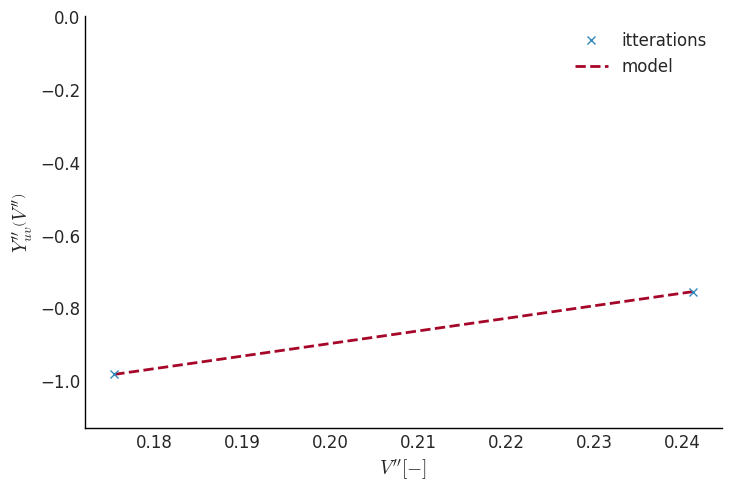

In [8]:
df_yuv = pd.DataFrame(pipeline_split.get_suffixed_derivatives(derivative='yuv'))
df_yuv['yvav'] = pipeline_split.get_suffixed_derivatives(derivative='yvav')
Vs_ = df_yuv.index
df_yuv['yuv_model'] = pipeline_split.derivatives['yuv'] + pipeline_split.derivatives['yuuv']*Vs_
df_yuv['yvav_model'] = pipeline_split.derivatives['yvav']

fig,ax=plt.subplots()
df_yuv.plot(y='yuv', label='itterations', style='x', zorder=10, ax=ax)
df_yuv.plot(y='yuv_model', label='model', style='--', ax=ax)
ax.set_ylabel(r"$Y_{uv}'' \left( V'' \right) $")
ax.set_xlabel(r"$ V'' [-] $")
ax.set_ylim((-1.13,0))
glue("regressionsplit",fig, display=False)


{numref}`informativepriors` shows the probability density functions (PDF) for hydrodynamic derivatives estimated with OLS regression on the whole dataset and the splitted regression.  

```{glue:figure} informativepriors
:name: "informativepriors"

PDF:s for the estimated derivatives with OLS regression and splitted OLS regression.
```

In [9]:
columns = list(X.columns)

#sigmas_ = [derivatives_std[key] for key in columns]
#mus_ = [derivatives[key] for key in columns]

sigmas_ = [pipeline_split.stds[key] for key in columns]
mus_ = [pipeline_split.derivatives[key] for key in columns]
data = df_
sigma_ = 0.0001*data['fy'].abs().max()

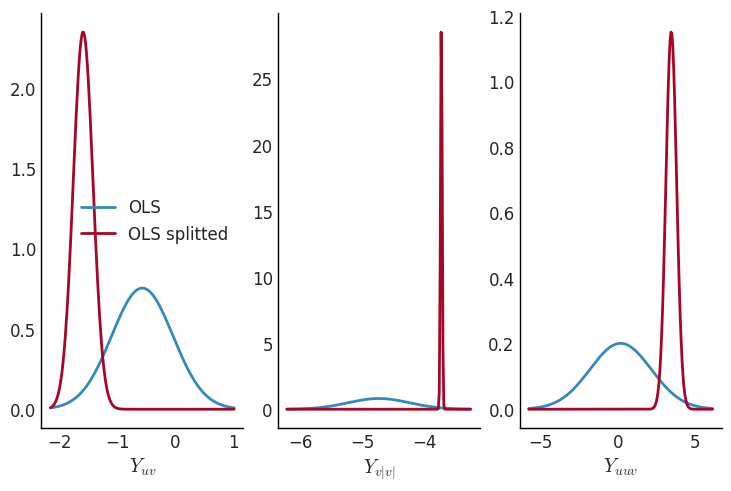

In [10]:
columns_sympy = {
    'yuv':Y_uv,
    'yuuv':Y_uuv,
    'yvav':Y_vav,
}
columns_latex = {key:f"${sp.latex(value)}$" for key,value in columns_sympy.items()}

#rvs_split_OLS = {key:norm(loc=derivatives[key], scale=derivatives_std[key]) for key in columns}
rvs_split_OLS = {key:norm(loc=pipeline_split.derivatives[key], scale=pipeline_split.stds[key]) for key in columns}
rvs_OLS = {key:norm(loc=regression.regression.params[key], scale=regression.regression.bse[key]) for key in columns}


fig,axes=plt.subplots(ncols=len(rvs_OLS))
for (key, rv),ax in zip(rvs_split_OLS.items(), axes.flatten()):
    
    rv_OLS = rvs_OLS[key]
    x_ = np.linspace(rv_OLS.mean() - 3*rv_OLS.std(), rv_OLS.mean() + 3*rv_OLS.std(), 200)
   
    ax.plot(x_, rv_OLS.pdf(x_), label='OLS')
    ax.plot(x_, rv.pdf(x_), label='OLS splitted')
    
        
    ax.set_xlabel(columns_latex[key])
    
axes[0].legend()
glue("informativepriors", fig, display=False)


The PDF:s from the splitted OLS regression can now be used as informative priors to do Bayesian inference of the parameters.

In [11]:
basic_model = pm.Model()



with basic_model:
    # Priors for unknown model parameters
    parameters = pm.Normal("parameters", mu=mus_, 
                           sigma=sigmas_, 
                           shape=len(columns))
    
    sigma = pm.HalfNormal("sigma", sigma=sigma_)

    # Expected value of outcome
    mu = pm.math.dot(X, parameters)

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("fy_obs", mu=mu, sigma=sigma, observed=y)
    #ν = pm.Uniform("ν", 1, 10)
    #Y_obs = pm.StudentT("fy_obs", nu=ν, mu=mu, sigma=sigma, observed=y)

In [12]:
with basic_model:
    prior = pm.sample_prior_predictive(samples=5000)
    trace = pm.sample(draws=10000)

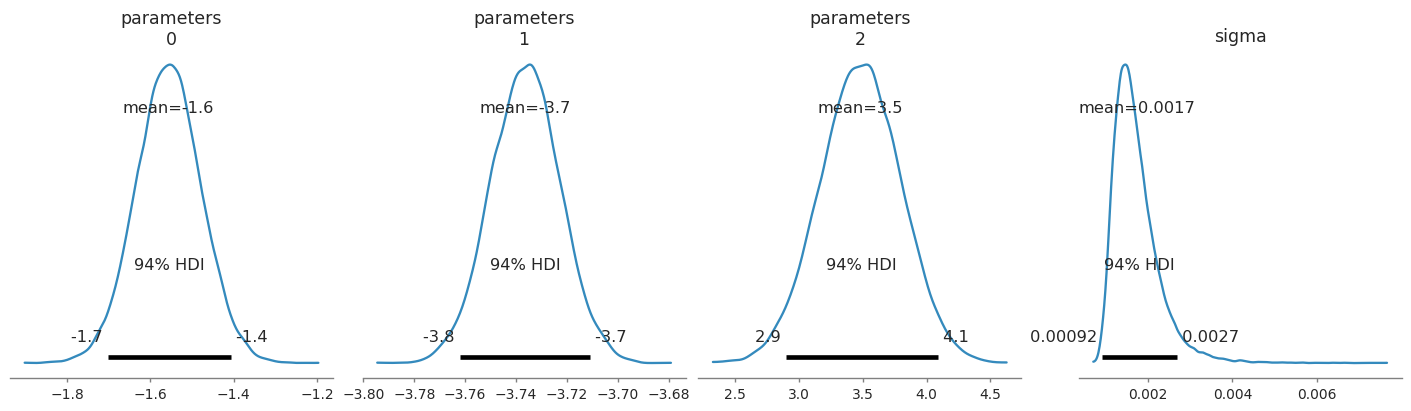

In [13]:
with basic_model:
    az.plot_posterior(trace,
                  var_names=['parameters','sigma'],
                  textsize=10,
                  point_estimate='mean',
                  rope_color='black',
                  figsize=(14,4))

In [14]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
parameters[0],-1.556,0.079,-1.701,-1.406,0.001,0.000,12501.0,11420.0,1.0
parameters[1],-3.736,0.014,-3.762,-3.711,0.000,0.000,15491.0,12636.0,1.0
parameters[2],3.480,0.316,2.897,4.086,0.003,0.002,13752.0,13278.0,1.0
sigma,0.002,0.001,0.001,0.003,0.000,0.000,13423.0,10423.0,1.0


In [15]:
df_parameters_posterior = pd.DataFrame(data = np.concatenate((trace.posterior['parameters'].data[0],trace.posterior['parameters'].data[1])), columns=columns)

```{glue:figure} bayesianinference
:name: "bayesianinference"

PDF:s for the estimated derivatives with OLS regression, splitted OLS regression and Bayesian inference.
```

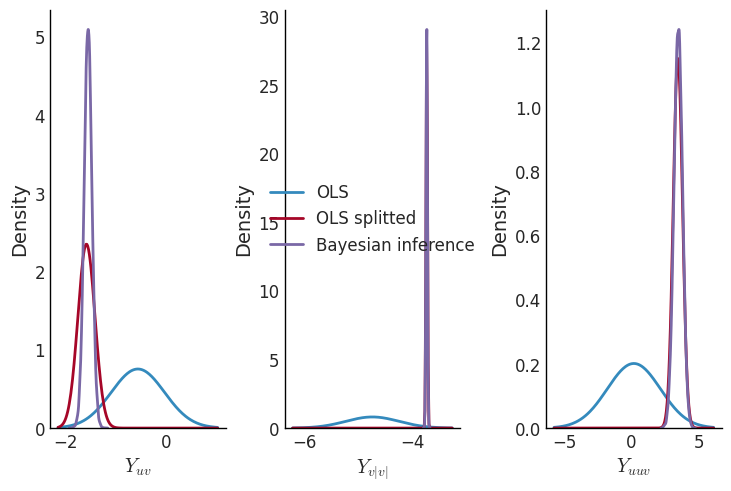

In [56]:
fig,axes=plt.subplots(ncols=len(rvs_OLS))
for (key, rv),ax in zip(rvs_split_OLS.items(), axes.flatten()):
    
    rv_OLS = rvs_OLS[key]
    x_ = np.linspace(rv_OLS.mean() - 3*rv_OLS.std(), rv_OLS.mean() + 3*rv_OLS.std(), 200)
   
    ax.plot(x_, rv_OLS.pdf(x_), label='OLS')
    ax.plot(x_, rv.pdf(x_), label='OLS splitted')
    sns.kdeplot(df_parameters_posterior[key], ax=ax, label='Bayesian inference')
        
    ax.set_xlabel(columns_latex[key])
    
axes[1].legend(loc='center')
glue("bayesianinference", fig, display=False)

In [17]:
means = (trace.posterior['parameters'].data[0].mean(axis=0) + trace.posterior['parameters'].data[1].mean(axis=0))/2
means = {key:mean for key,mean in zip(columns,means)}

In [18]:
stds = (trace.posterior['parameters'].data[0].std(axis=0) + trace.posterior['parameters'].data[1].std(axis=0))/2
stds = {key:std for key,std in zip(columns,stds)}

In [19]:
df_parameters = pd.concat([
pd.Series(means, name='Bayesian'),
pd.Series({key:derivatives[key] for key in means.keys()}, name='splitted OLS'),
pd.Series({key:regression.regression.params[key] for key in means.keys()}, name='OLS'),
    
], axis=1).transpose()

```{glue:figure} estimations
:name: "estimations"

Estimated hydrodynamic derivatives with the various methods.
```

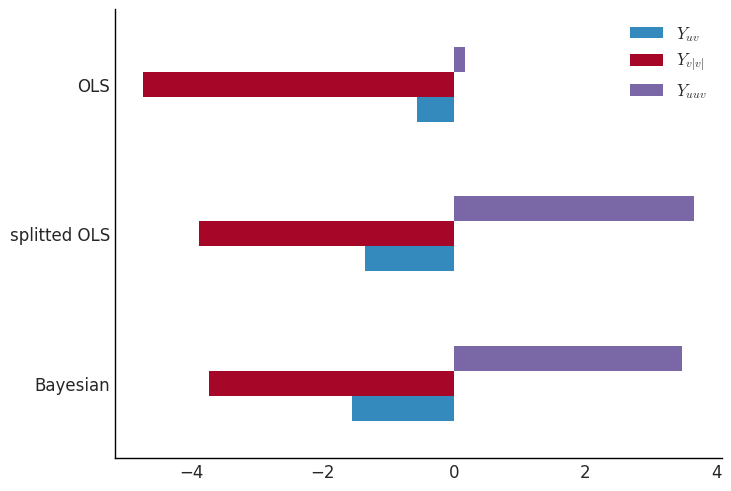

In [21]:
fig,ax=plt.subplots()
df_parameters.rename(columns=columns_latex).plot.barh(ax=ax)
glue("estimations",fig, display=False)